[57,80,22]
[57,79,22]
[57,78,22]
[57,77,22]
[57,76,22]
[57,75,22]
[57,74,22]
[57,73,22]
[57,72,22]
[57,70,22]
[56,71,23]
[56,73,25]
[56,72,26]
[57,71,27]
[58,71,28]
[59,71,29]
[60,70,28]
[61,70,27]
[62,69,27]
[63,68,27]
[64,68,28]
[65,67,28]
[66,67,28]
[67,66,28]
[68,65,27]
[69,64,27]
[71,64,28]
[71,63,27]
[72,62,26]
[73,61,26]
[74,60,26]
[74,59,25]
[75,57,24]
[74,57,22]
[74,56,22]
[74,55,22]
[74,54,22]
[74,53,22]
[74,52,21]
[73,50,19]
[72,50,18]
[72,50,17]
[71,50,16]
[70,50,15]
[70,50,14]
[70,50,13]
[70,50,12]
[70,50,11]
[71,49,10]
[71,48,9]
Finsh 2368


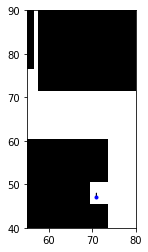

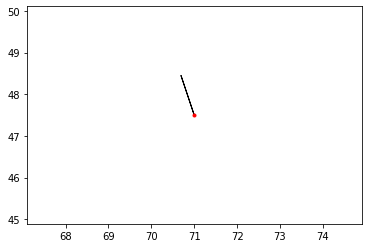

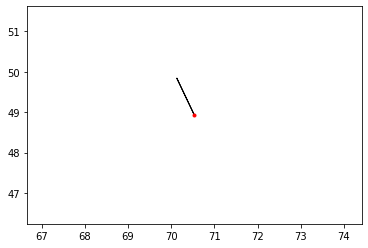

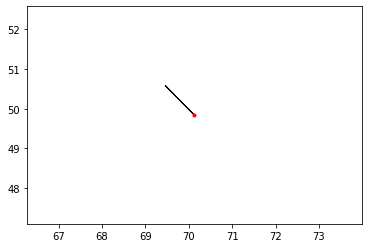

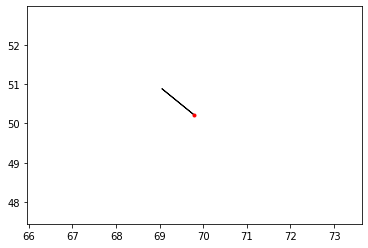

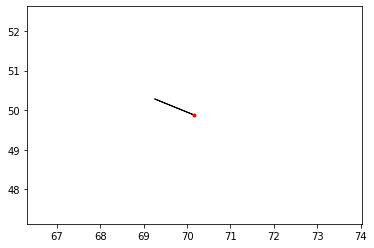

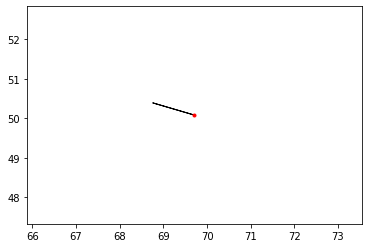

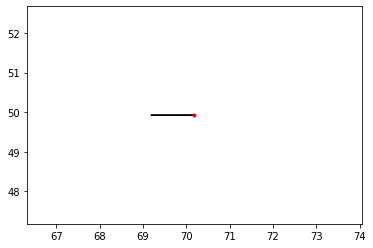

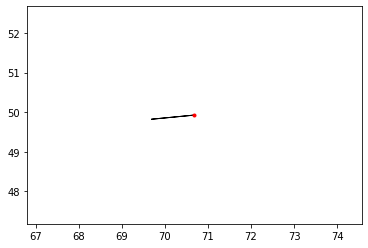

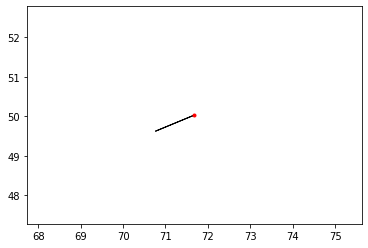

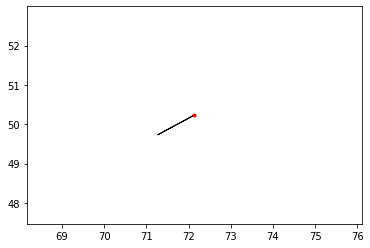

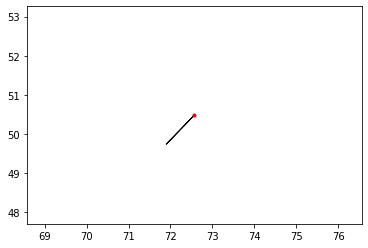

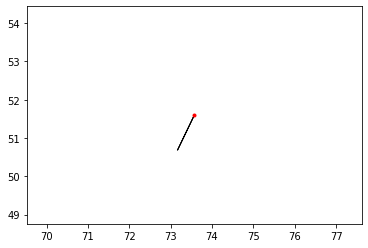

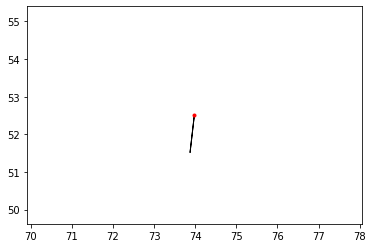

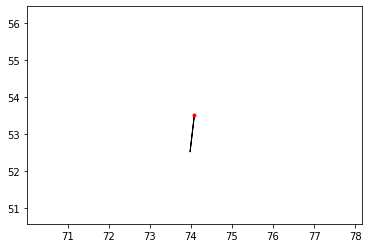

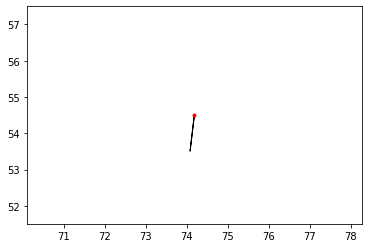

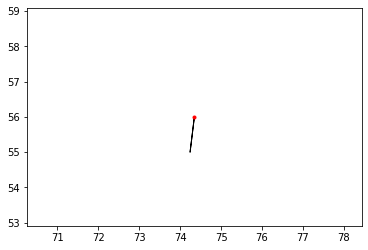

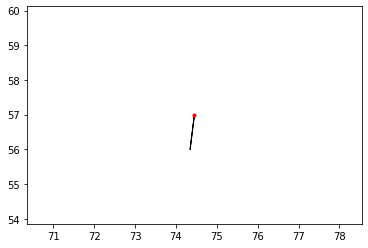

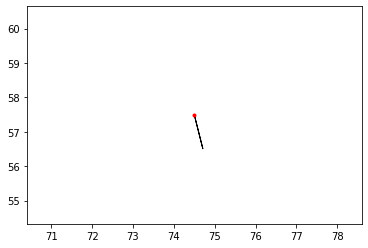

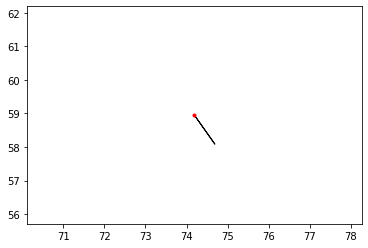

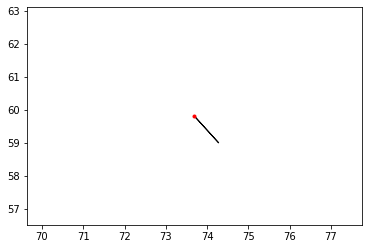

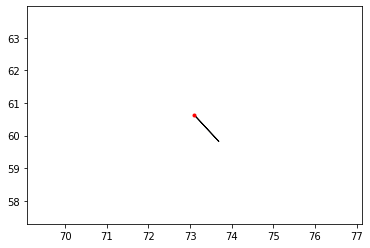

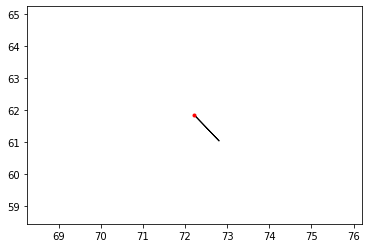

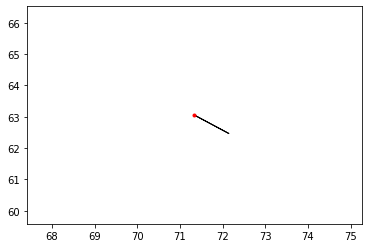

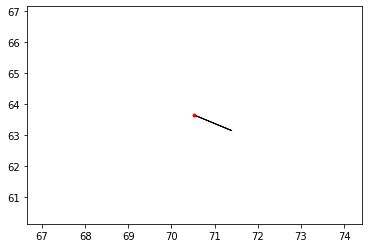

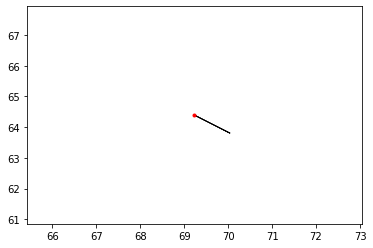

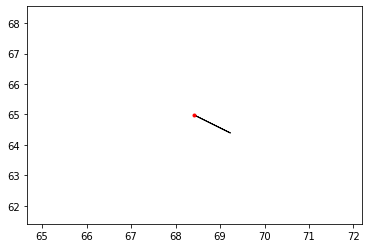

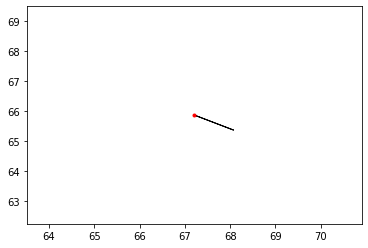

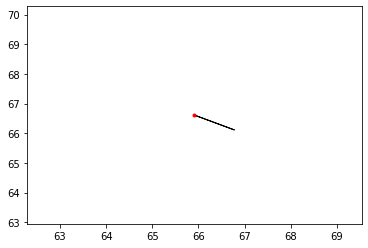

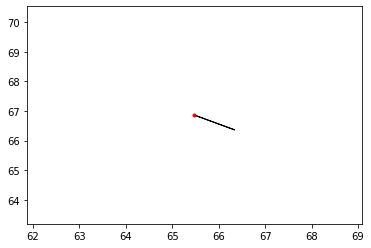

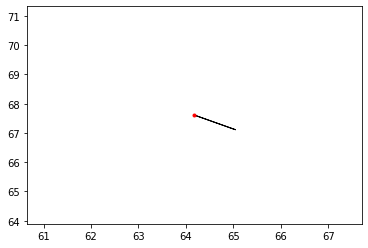

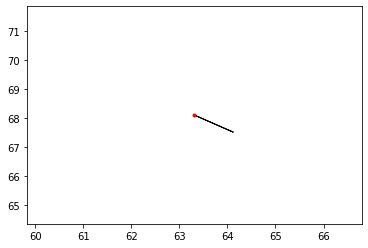

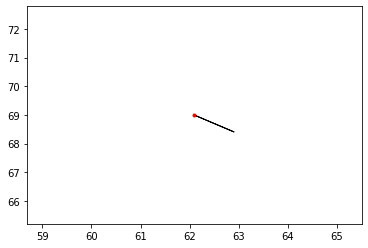

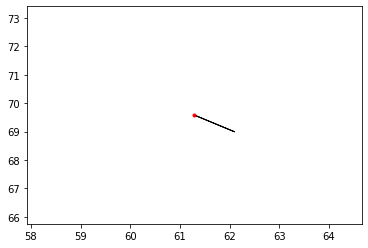

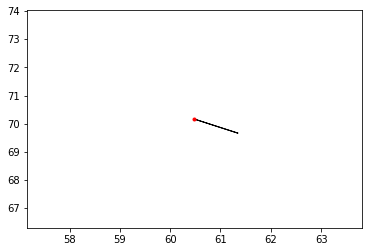

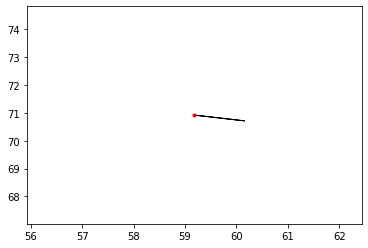

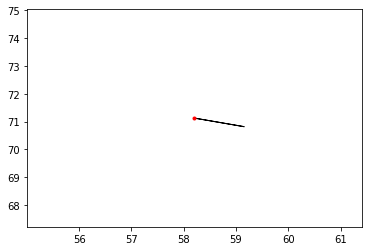

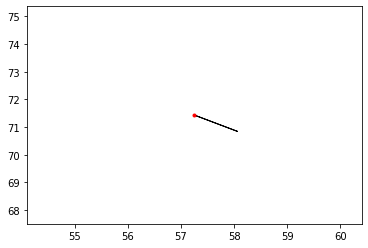

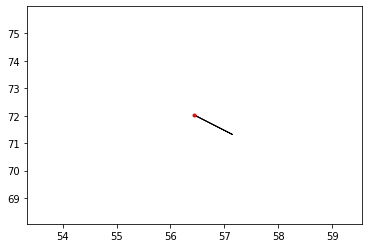

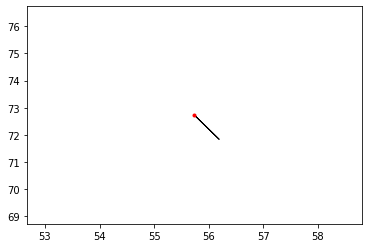

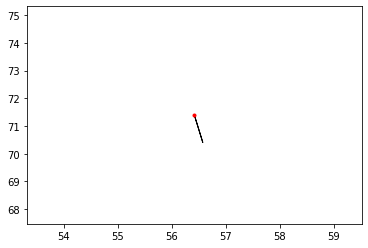

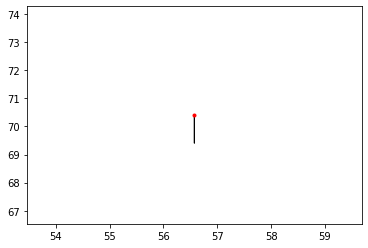

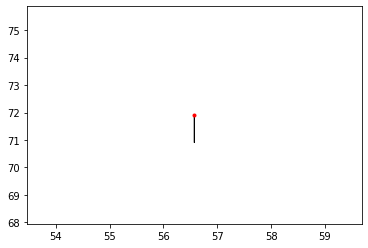

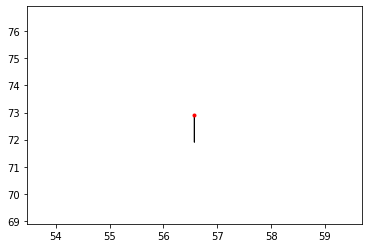

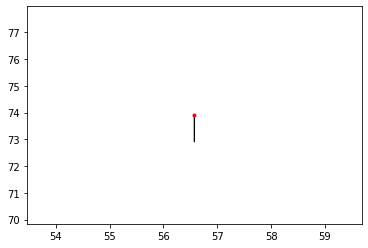

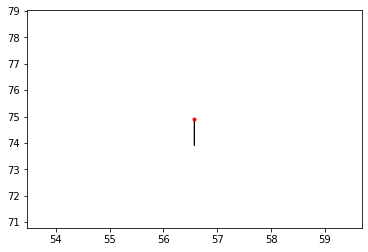

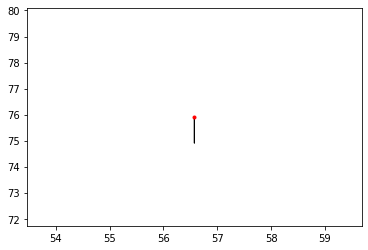

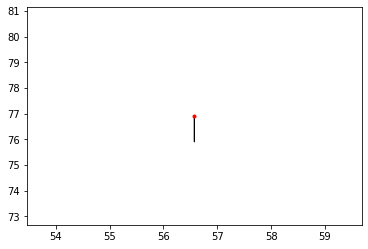

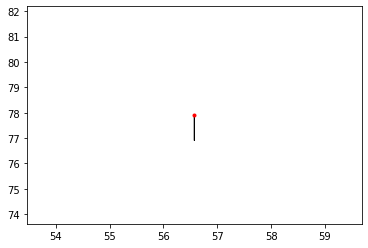

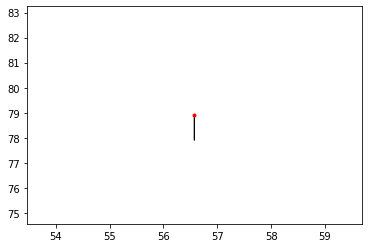

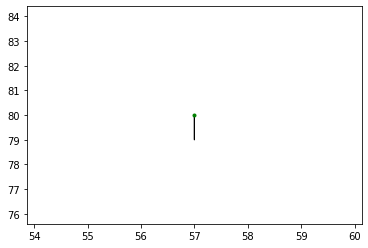

In [3]:
# %load hybrid_A_star.py
# hybrid A* 

import numpy as np
import matplotlib.pyplot as plt
import math as m
from map_load.map_load import load_img, rgb2gray

# Parameter
PI = m.pi
deltaT = 0.1 #time step
V_set = [-1.5,-1,-0.5,0.5,1,1.5] # velocity sample set
W_set = [0,PI/2,-PI/2,PI,-PI,PI/3,-PI/3] # angular velocity sample set
resX = 0.1 # resolution of X
resY = 0.1 # resolution of Y
resTH = PI/15 # resolution of theta


'''
Class node contain
    C : configuration [X,Y,TH]  continuous configuration record
    P : Parent node Id
    Id : the decrete configuration of node
    G : actual cost
    H : ecpected cost
    COST : G + H (need cost parameter)
'''

class node():
    def __init__(self, C, P):
        self.C = C
        self.P = P
        self.Id = '[' + str(int(np.round(self.C[0]/resX))) + ',' +  str(int(np.round(self.C[1]/resY))) + ',' + str(int(np.round(self.C[2]/resTH))) + ']'
        
    def Set_cost(self, G, H):
        self.G = G
        self.H = H
        self.COST = self.G + self.H

def angle_correct(angle):
    angle = m.fmod(angle, 2*PI)
    if angle < 0:
        angle = angle + 2*PI
    return angle


'''
motionMode is used to  help agent to predict the configuration after choose some action.
'''
def motionMode(C, V, W):
    Xp = C[0]
    Yp = C[1]
    THp = C[2]
    X = Xp + V * deltaT * m.cos(THp)
    Y = Yp + V * deltaT * m.sin(THp)
    TH = THp + W * deltaT
    TH = angle_correct(TH)
    
    return [X,Y,TH]


'''
calculate COST
'''
def Cost_cal(Nn, Ng, Vn, Wn, V, W):
    G = abs(V) + abs(W)
    H = m.sqrt(abs(Nn.C[0] - Ng.C[0])**2 + abs(Nn.C[1] - Ng.C[1])**2) + abs(Nn.C[2] - Ng.C[2])

    return G, H

'''
Function ExpandNode try to expand node from the node now.
It chooses action from sample set, then creat new nodes, calculate the cost, add them into open set 'So' after check the nodes aren't
in close set 'Sc', the G cost is less than a older one
'''

    
def ExpandNode(N, Ng, So, Sc):
    for V in V_set:
        for W in W_set:
            C_temp = motionMode(N.C, V, W)
            temp = node(C_temp, N.Id)
            G, H = Cost_cal(temp, Ng, 0, 0, V, W)
            temp.Set_cost(G + N.G,30*H)
            if temp.Id in Sc:
                a = 1
            elif temp.Id in So:
                if temp.G <= So[temp.Id].G:
                    So[temp.Id] = temp
            else:
                So[temp.Id] = temp
                
    return So


'''
Function find_min_cost will return the minimum cost node from the input set
'''

def find_min_cost(S):
    min_node = node([999,999,999],0)
    min_node.Set_cost(9999999,99999999999)
    for i in S:
        if S[i].COST < min_node.COST:
            min_node = S[i]

    return min_node


'''
A* process:
    Start by adding the start node into open set, then repeat:
    
    find the minimum cost node in open set
    expand nodes from the minimun cost node, and adding them into open set
    move the minimun cost node from open set to closed set

    repeat until the goal node in the closed set
'''

def hybrid_A_star_process(Ns, Ng, So, Sc):
    So[Ns.Id] = Ns
    i = 0
    while Ng.Id not in Sc:
        Nn = find_min_cost(So)
        So = ExpandNode(Nn, Ng, So, Sc)
        Sc[Nn.Id] = Nn
        del So[Nn.Id]
        i = i + 1
    return So, Sc, i


def Get_path(S, Ns, Ng):
    Path = []
    Nn = Ng
    while Nn.Id != Ns.Id:
        print(Nn.Id)
        Path.append(Nn.C)
        Nn = S[S[Nn.Id].P]
    Path.append(Nn.C)
    Path.reverse()
    return Path


def set_obs(Sc, im):
    [x_size, y_size] = np.shape(im)
    im_c = [[0 for i in range(x_size)] for j in range(y_size)]
    for i in range(0,x_size-1):
        for j in range(0,y_size-1):
            im_c[x_size-i-1][j] = im[i,j]
            if im[i,j] <= 0.9:
                for k in range(0,int(2*PI/resTH + 1)):
                    Id = '[' + str(j) + ',' +  str(x_size - i - 1) + ',' + str(k) + ']'                    
                    Sc[Id] = 'obs'
                #print(Id)
    return Sc, im_c
                    
                    
def Show_path(Path):
    for i in range(len(Path)):
        if i == 0:
            plt.plot(Path[i][0]/resX,Path[i][1]/resY,'b.')
            plt.arrow(Path[i][0]/resX,Path[i][1]/resY,1*m.cos(Path[i][2]),1*m.sin(Path[i][2]))
            plt.pause(0.05)
        elif i == len(Path) - 1:
            plt.plot(Path[i][0]/resX,Path[i][1]/resY,'g.')
            plt.arrow(Path[i][0]/resX,Path[i][1]/resY,1*m.cos(Path[i][2]),1*m.sin(Path[i][2]))
            plt.pause(0.05)
        else:
            plt.plot(Path[i][0]/resX,Path[i][1]/resY,'r.')
            plt.arrow(Path[i][0]/resX,Path[i][1]/resY,1*m.cos(Path[i][2]),1*m.sin(Path[i][2]))
            plt.pause(0.05)
        #plt.savefig('image/temp/'+str(i)+'.png')

            

if __name__ == '__main__':
    image = rgb2gray(load_img('map_load/map/test6.png'))
    a = node([7.1,4.7,PI/2],1)
    a.Set_cost(0,0)
    b = node([5.7,8,3*PI/2],1)
    Sop = {}
    Scl = {}
    Scl, im_c = set_obs(Scl, image)
    plt.imshow(im_c, cmap='Greys_r', origin='lower')
    plt.axis([55,80,40,90])
    Sop, Scl, i = hybrid_A_star_process(a,b,Sop,Scl)
    Path = Get_path(Scl,a,b)
    print('Finsh',i)
    Show_path(Path)
